IPYNB notebook to preprocess data imported from matlab, and convert it into the format accepted by the input

plotting the experimental data

In [1]:
import scipy.io
import pandas as pd
import matplotlib as plt
import numpy as np
from matplotlib import pyplot
from matplotlib import markers

Text(0.5, 1.0, 'PBCO experimental fitted peaks')

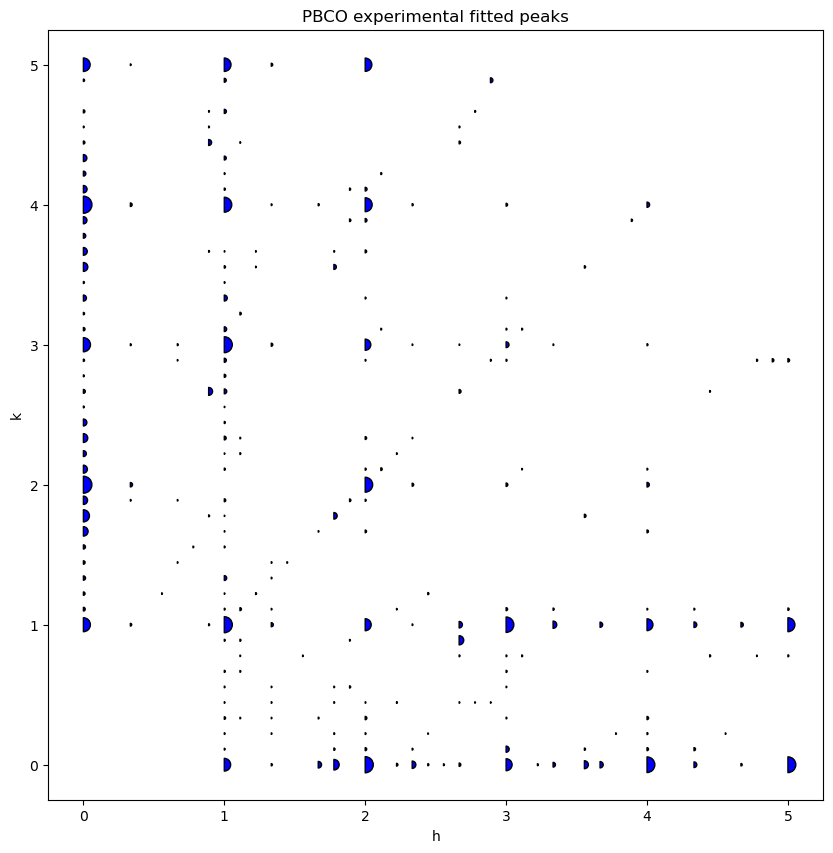

In [2]:
# Load data
h_coords = pd.read_csv('raw_data/h_coords.csv', header=None).values.flatten()
k_coords = pd.read_csv('raw_data/k_coords.csv', header=None).values.flatten()
intensity_arr = pd.read_csv('raw_data/intensity_arr.csv', header=None).values

h , k = np.meshgrid(h_coords , k_coords)

h_flat = h.flatten()
k_flat = k.flatten()
intensity_flat = intensity_arr.flatten()

copy_h_flat = h_flat
h_flat = k_flat
k_flat = copy_h_flat


pyplot.scatter(h_flat , k_flat , s=intensity_flat * 50  , color='blue', edgecolor="black",
               label='Exp', marker=markers.MarkerStyle("o", fillstyle="right"))
#change figure size
pyplot.gcf().set_size_inches(10, 10)
#add labels
pyplot.xlabel('h')
pyplot.ylabel('k')
#add title
pyplot.title('PBCO experimental fitted peaks')

create a csv file with 4 columns. first column is for h_coords, then for k_coords, and then for l_coords (all equal to 0). then another row for the experimental intensity, with title 'intensity_exp'.

In [4]:
#create a csv file with the data, and each first row is the name of the column : h ,k , l , intensity_exp
data = pd.DataFrame({
    'h': h_flat,
    'k': k_flat,
    'l': np.zeros_like(h_flat),  # Assuming l is zero for this exampleP
    'intensity_exp': intensity_flat,
    'intensity_exp_err' : np.zeros_like(h_flat)
})

#remove all the rows where intensity_exp is zero
data = data[data['intensity_exp'] != 0]

#remove all rows where h and k are both integers
data = data[~((data['h'] % 1 == 0) & (data['k'] % 1 == 0))]


data.to_csv('raw_data/peaks.csv', index=False)

print(data)

             h         k    l  intensity_exp  intensity_exp_err
10    0.000000  1.111111  0.0       0.144402                0.0
11    0.000000  1.222222  0.0       0.116108                0.0
12    0.000000  1.333333  0.0       0.191090                0.0
13    0.000000  1.444444  0.0       0.122405                0.0
14    0.000000  1.555556  0.0       0.179914                0.0
...        ...       ...  ...            ...                ...
2004  4.777778  2.888889  0.0       0.045682                0.0
2050  4.888889  2.888889  0.0       0.108925                0.0
2077  5.000000  0.777778  0.0       0.037683                0.0
2080  5.000000  1.111111  0.0       0.059146                0.0
2096  5.000000  2.888889  0.0       0.113943                0.0

[217 rows x 5 columns]


Find where to add the shifts in the list of atom coordinates. 

add the atom displacement distortions

In [67]:
#load a text file into a dataframe
PBCO_coords = pd.read_csv('raw_data/PBCO_coords.txt' , delim_whitespace=True, header=None)
PBCO_distortions = pd.read_csv('raw_data/PBCO_atom_site_fract_symmform.txt' , delim_whitespace=True, header=None)

#load PBCO_distortions into a list of lists
PBCO_distortions = PBCO_distortions.values.tolist()
PBCO_coords = PBCO_coords.values.tolist()

#create a new column in PBCO_distortions, which adds the second column up cumulatively
PBCO_distortions = pd.DataFrame(PBCO_distortions)
PBCO_coords = pd.DataFrame(PBCO_coords)

PBCO_coords[2] = PBCO_coords[2].astype(str)
PBCO_coords[3] = PBCO_coords[3].astype(str)
PBCO_coords[4] = PBCO_coords[4].astype(str)

print(PBCO_distortions)

PBCO_distortions[5] = PBCO_distortions[1].cumsum()

#create a list to store all the names of shift name variables
shift_names = []

for i in range(len(PBCO_distortions)):
    #take the ith and ith + 1 element in the last column, and load them into a variable called num_atom_start and num_atom_end. if i is 1 , then num_atom_start must equal to 1, and num_atom_end must equal to the first element in the last column
    if i == 0:
        num_atom_start = 0
        num_atom_end = PBCO_distortions.iloc[i, -1]
    else:
        num_atom_start = PBCO_distortions.iloc[i, -1] - PBCO_distortions.iloc[i, 1]
        num_atom_end = PBCO_distortions.iloc[i, -1]
    
    #check if there are Dx , Dy , Dz in the 3rd , 4th and 5th columns of PBCO_distortions
    if 'Dx' in PBCO_distortions.iloc[i, 2]:
        #string the char in the first column ith row to 'Dx'
        dx_shift_name = PBCO_distortions.iloc[i, 0] + '_Dx'
    else:
        dx_shift_name = 0
    if 'Dy' in PBCO_distortions.iloc[i, 3]:
        #string the char in the first column ith row to 'Dy'
        dy_shift_name = PBCO_distortions.iloc[i, 0] + '_Dy'
    else:
        dy_shift_name = 0
    if 'Dz' in PBCO_distortions.iloc[i, 4]:
        #string the char in the first column ith row to 'Dz'
        dz_shift_name = PBCO_distortions.iloc[i, 0] + '_Dz' 
    else:
        dz_shift_name = 0



    if dx_shift_name != 0:
        shift_names.append(dx_shift_name)
        for j in range(num_atom_start, num_atom_end):
            PBCO_coords.iloc[j, 2] = str(PBCO_coords.iloc[j, 2] + ' + ') + dx_shift_name
    if dy_shift_name != 0:
        shift_names.append(dy_shift_name)
        for j in range(num_atom_start, num_atom_end):
            PBCO_coords.iloc[j, 3] = str(PBCO_coords.iloc[j, 3] + ' + ') + dy_shift_name
    if dz_shift_name != 0:
        shift_names.append(dz_shift_name)
        for j in range(num_atom_start, num_atom_end):
            PBCO_coords.iloc[j, 4] = str(PBCO_coords.iloc[j, 4] + ' + ') + dz_shift_name


for k in range(len(PBCO_coords)):
    PBCO_coords.iloc[k, 0] = str("['" + PBCO_coords.iloc[k, 0] + "'")
    PBCO_coords.iloc[k, 2] = str('[' + PBCO_coords.iloc[k, 2])
    PBCO_coords.iloc[k, 4] = str(PBCO_coords.iloc[k, 4] + "]],")

print(PBCO_coords)
#save PBCO_coords to a csv file
PBCO_coords.to_csv('raw_data/PBCO_coords_processed.txt', index=False, header=False)


print(shift_names)
# Convert shift_names to a DataFrame
shift_names = pd.DataFrame(shift_names)
#print all shift_names into a single line
shift_names_txt = shift_names[0].str.cat(sep=', ')
print(shift_names)
# Save shift_names to a text file
with open('raw_data/shift_names.txt', 'w') as f:
    f.write(shift_names_txt)


C:\Users\User\AppData\Local\Temp\ipykernel_25560\2781394630.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  PBCO_coords = pd.read_csv('raw_data/PBCO_coords.txt' , delim_whitespace=True, header=None)
C:\Users\User\AppData\Local\Temp\ipykernel_25560\2781394630.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  PBCO_distortions = pd.read_csv('raw_data/PBCO_atom_site_fract_symmform.txt' , delim_whitespace=True, header=None)


         0  1   2   3   4
0    Pr1_1  4  Dx   0  Dz
1    Pr1_2  4  Dx   0  Dz
2    Pr1_3  4  Dx   0  Dz
3    Pr1_4  4  Dx   0  Dz
4    Pr1_5  2  Dx   0   0
..     ... ..  ..  ..  ..
195  O4_21  4  Dx  Dy   0
196  O4_22  8  Dx  Dy  Dz
197  O4_23  8  Dx  Dy  Dz
198  O4_24  8  Dx  Dy  Dz
199  O4_25  8  Dx  Dy  Dz

[200 rows x 5 columns]
          0     1                    2                  3  \
0     ['Pr'  '59'  [0.94444 + Pr1_1_Dx                0.5   
1     ['Pr'  '59'  [0.05556 + Pr1_1_Dx                0.5   
2     ['Pr'  '59'  [0.05556 + Pr1_1_Dx                0.5   
3     ['Pr'  '59'  [0.94444 + Pr1_1_Dx                0.5   
4     ['Pr'  '59'  [0.94444 + Pr1_2_Dx                0.5   
...     ...   ...                  ...                ...   
1048   ['O'   '8'  [0.44444 + O4_25_Dx  0.8416 + O4_25_Dy   
1049   ['O'   '8'  [0.55556 + O4_25_Dx  0.8416 + O4_25_Dy   
1050   ['O'   '8'  [0.44444 + O4_25_Dx  0.1584 + O4_25_Dy   
1051   ['O'   '8'  [0.44444 + O4_25_Dx  0.8416 + O4_25

Preprocess get mode amplitudes

In [167]:
mode_names = pd.read_csv('raw_data/displacivemode_names.txt' , delim_whitespace=True, header=None)
mode_matrix = pd.read_csv('raw_data/mode_matrix.txt' , delim_whitespace=True, header=None)

#CONVERT TO A LIST OF LISTS
mode_names = mode_names.values.tolist()

# Convert mode_names to a DataFrame
mode_names = pd.DataFrame(mode_names)

num_modes = len(mode_names) 
print(num_modes)

mode_name1 = []
# rewrite the mode names into a new list with the first column as the mode name 
for i in range(num_modes):
    mode_name1.append(str('"' + str(mode_names.iloc[i, 1]) + '"' + ': '))

print(mode_name1)


445
['"[1/9,1/9,0]V1(a,0;a,0)[Pr1:h:dsp]B3u(a)": ', '"[1/9,1/9,0]V1(a,0;a,0)[Pr1:h:dsp]B2u(a)": ', '"[0,1/9,0]DT1(a,0)[Pr1:h:dsp]B2u(a)": ', '"[0,2/9,0]DT1(a,0)[Pr1:h:dsp]B2u(a)": ', '"[0,1/3,0]DT1(a,0)[Pr1:h:dsp]B2u(a)": ', '"[0,4/9,0]DT1(a,0)[Pr1:h:dsp]B2u(a)": ', '"[1/9,0,0]SM1(a,0)[Pr1:h:dsp]B3u(a)": ', '"[2/9,0,0]SM1(a,0)[Pr1:h:dsp]B3u(a)": ', '"[1/3,0,0]SM1(a,0)[Pr1:h:dsp]B3u(a)": ', '"[4/9,0,0]SM1(a,0)[Pr1:h:dsp]B3u(a)": ', '"[1/9,2/9,0]V1(a,0;a,0)[Pr1:h:dsp]B3u(a)": ', '"[1/9,2/9,0]V1(a,0;a,0)[Pr1:h:dsp]B2u(a)": ', '"[1/9,1/3,0]V1(a,0;a,0)[Pr1:h:dsp]B3u(a)": ', '"[1/9,1/3,0]V1(a,0;a,0)[Pr1:h:dsp]B2u(a)": ', '"[1/9,4/9,0]V1(a,0;a,0)[Pr1:h:dsp]B3u(a)": ', '"[1/9,4/9,0]V1(a,0;a,0)[Pr1:h:dsp]B2u(a)": ', '"[2/9,1/9,0]V1(a,0;a,0)[Pr1:h:dsp]B3u(a)": ', '"[2/9,1/9,0]V1(a,0;a,0)[Pr1:h:dsp]B2u(a)": ', '"[2/9,2/9,0]V1(a,0;a,0)[Pr1:h:dsp]B3u(a)": ', '"[2/9,2/9,0]V1(a,0;a,0)[Pr1:h:dsp]B2u(a)": ', '"[2/9,1/3,0]V1(a,0;a,0)[Pr1:h:dsp]B3u(a)": ', '"[2/9,1/3,0]V1(a,0;a,0)[Pr1:h:dsp]B2u(a)": ', '

C:\Users\User\AppData\Local\Temp\ipykernel_25560\395762485.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mode_names = pd.read_csv('raw_data/displacivemode_names.txt' , delim_whitespace=True, header=None)
C:\Users\User\AppData\Local\Temp\ipykernel_25560\395762485.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mode_matrix = pd.read_csv('raw_data/mode_matrix.txt' , delim_whitespace=True, header=None)


In [168]:
#make a zeros array with len(shift_names) rows and columns
mode_np_matrix = np.zeros((num_modes, num_modes))

print(mode_np_matrix.shape)
print(mode_np_matrix)

#load the third column values from mode_matrix into mode_np_matrix.first column of ith row is the row number of the matrix, second column is the column number of the matrix, third column is the value of the matrix
for i in range(len(mode_matrix)):
    row = mode_matrix.iloc[i, 0] - 1
    col = mode_matrix.iloc[i, 1] - 1
    value = mode_matrix.iloc[i, 2]
    mode_np_matrix[row, col] = value

print(mode_np_matrix)


print(mode_name1)


for row in range(num_modes):
    for col in range(num_modes):
        if mode_np_matrix[row, col] != 0:
            shift_name = shift_names.iloc[col,0]
            
            if mode_np_matrix[row, col] < 0:
                matrix_element = mode_np_matrix[row, col] * -1
                string_mode_np_matrix = str(matrix_element)
                dependent = ' - ' + string_mode_np_matrix + ' * ' + shift_name
            else:
                string_mode_np_matrix = str(mode_np_matrix[row, col])
                dependent = ' + ' + string_mode_np_matrix + ' * ' + shift_name
            
            mode_name1[row] = str(mode_name1[row]) + dependent
        else:
            mode_name1[row] = str(mode_name1[row])



# Save mode_names to a text file without using pandas
with open('raw_data/mode_names_processed.txt', 'w') as f:
    for name in mode_name1:
        f.write(name + ',' + '\n')


'''mode_names_txt = pd.DataFrame(mode_name1)
mode_names_txt.to_csv('raw_data/mode_names_processed.txt', index=False, header=False)

'''


(445, 445)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[-0.32635  0.       0.      ...  0.       0.       0.     ]
 [ 0.       0.32635  0.3473  ...  0.       0.       0.     ]
 [-0.17365  0.       0.      ...  0.       0.       0.     ]
 ...
 [ 0.       0.       0.      ...  0.       0.      -0.17365]
 [ 0.       0.       0.      ...  0.03015  0.       0.     ]
 [ 0.       0.       0.      ...  0.      -0.17365  0.     ]]
['"[1/9,1/9,0]V1(a,0;a,0)[Pr1:h:dsp]B3u(a)": ', '"[1/9,1/9,0]V1(a,0;a,0)[Pr1:h:dsp]B2u(a)": ', '"[0,1/9,0]DT1(a,0)[Pr1:h:dsp]B2u(a)": ', '"[0,2/9,0]DT1(a,0)[Pr1:h:dsp]B2u(a)": ', '"[0,1/3,0]DT1(a,0)[Pr1:h:dsp]B2u(a)": ', '"[0,4/9,0]DT1(a,0)[Pr1:h:dsp]B2u(a)": ', '"[1/9,0,0]SM1(a,0)[Pr1:h:dsp]B3u(a)": ', '"[2/9,0,0]SM1(a,0)[Pr1:h:dsp]B3u(a)": ', '"[1/3,0,0]SM1(a,0)[Pr1:h:dsp]B3u(a)": ', '"[4/9,0,0]SM1(a,0)[Pr1:h:dsp]B3u(a)": ', '"[1/9,2/9,0]V1(a,0;a,0)[Pr1:h

"mode_names_txt = pd.DataFrame(mode_name1)\nmode_names_txt.to_csv('raw_data/mode_names_processed.txt', index=False, header=False)\n\n"